# Continuous Prediction, Continued...
In this lab, we will learn how to use machine learning 
estimators for continuous predictions. These models
do not have the rigid assumptions of classical linear 
regression, which makes them more flexible; however,
the fitted models are essentially a black box. This
limits insights into the variables that contribute
to accuracy.

We will continue with the loan quality dataset. We
will use several different machine learning algorithms
and compare the new results with the linear regressions
from last week.

# Predicting Loan Quality

One of the most imporant aspects of lending is determining the
interest rate to give a customer. Set rates too high, and the
customer may choose another lender. Set rates too low, and 
lender may not earn enough interest to offset defaults and other expenses.

The data for this exercise comes from Lending Club, a peer-to-peer lending company.
They facilitate loans and allow individuals to make loans or borrow money (you 
can read more about them on 
[Wikipedia](https://en.wikipedia.org/wiki/Lending_Club).

Download the loan data that is on Blackboard. This is not the newest data, 
but it has the outcomes of many loans that have reached maturity. We can use the first dataset
to train and the second to test. You should also download the data dictionary. 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import metrics

## Preprocessing
First, let's read in the dataframe.

In [3]:
ld = pd.read_csv('data/lendingclub_2015-2018.csv')

/var/folders/ll/5fnyw07s0p74sdfnrqqwwhgc0000gn/T/ipykernel_43669/3818941270.py:1: DtypeWarning: Columns (20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  ld = pd.read_csv('data/lendingclub_2015-2018.csv')


## Subsampling

The size of this dataset causes model training to take a very long time. 
I will take a random subsample to speed up the process. 

In [4]:
ld = ld.sample(100000, random_state=516)

In [5]:
# the subsampling above has the rows in random order
# this orders the rows on the index column.
ld.sort_index(inplace=True)

### Loan Amount
First, let's look at the distribution of loan amounts.

<AxesSubplot:>

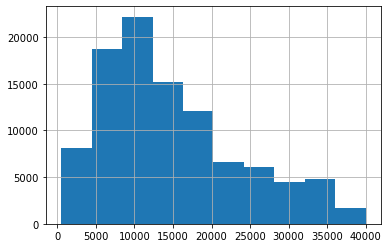

In [6]:
ld['loan_amnt'].hist()

### Annual Income
Annual income is not as neatly distributed as some of the other variables. There are several observations that report income of greater than \$1mn, and 
many who report no income at all.

<AxesSubplot:>

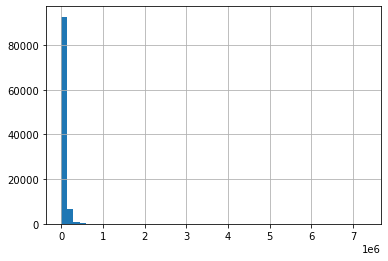

In [7]:
ld['annual_inc'].hist(bins=50)

### Rescaling
Some of the columns that we will use are on very different scales. For example, loan amount and annual income range from 0 to tens of thousands of dollars,
whereas the debt-to-income (`dti`) range is much smaller. This can cause issues when fitting the models.

We will transform the income variable using a log transformation. This will make the distribution closer to a bell curve. I added 1 to annual
income, since $log(0)$ is undefined.


<AxesSubplot:>

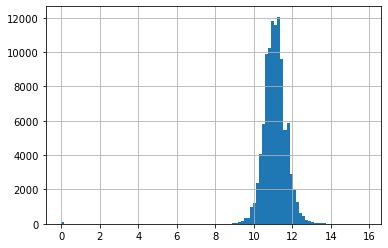

In [8]:
ld['log_annual_inc'] = np.log(ld['annual_inc']+1)
ld['log_annual_inc'].hist(bins=100)

### Loan Duration
The loan duration column is formatted as a text string, and must be cleaned up for analysis.

In [9]:
# view unique values
ld['term'].unique()

# split rows into parts
term_split = ld['term'].str.split(' ')

# view first five rows
print(term_split[:5])

4     [, 36, months]
6     [, 36, months]
11    [, 36, months]
13    [, 36, months]
16    [, 36, months]
Name: term, dtype: object


In [10]:
# the str function can retrieve a specific list element for all rows
term_split.str[1]
ld['duration'] = term_split.str[1]

# add this to the dataframe
display(ld['duration'].head())
# this column is not in integer format. Must fix!

4     36
6     36
11    36
13    36
16    36
Name: duration, dtype: object

In [11]:
# convert column to integer
ld['duration'] = ld['duration'].apply(int)
display(ld['duration'].head())

4     36
6     36
11    36
13    36
16    36
Name: duration, dtype: int64

## Descriptives
After doing general data cleaning, produce descriptive stats for all numerical columns.

In [12]:
descriptives = ld.describe()
print(descriptives)

              index            id  member_id      loan_amnt    funded_amnt  \
count  100000.00000  1.000000e+05        0.0  100000.000000  100000.000000   
mean   124842.97264  8.024008e+07        NaN   15044.947750   15040.144500   
std     72085.70044  4.499191e+07        NaN    9177.620881    9176.430228   
min         4.00000  9.327700e+04        NaN     500.000000     500.000000   
25%     62547.75000  4.497635e+07        NaN    8000.000000    8000.000000   
50%    124541.00000  8.434902e+07        NaN   12800.000000   12800.000000   
75%    187384.50000  1.223612e+08        NaN   20000.000000   20000.000000   
max    249995.00000  1.456423e+08        NaN   40000.000000   40000.000000   

       funded_amnt_inv       int_rate    installment    annual_inc  \
count    100000.000000  100000.000000  100000.000000  1.000000e+05   
mean      15022.270052      13.085624     445.303939  7.787106e+04   
std        9180.568392       4.844571     266.093421  7.646135e+04   
min           0.0

### Correlations
Let's run some correlations to see how some columns relate to one another

In [13]:
cols = ['int_rate', 'loan_amnt', 'installment', 'log_annual_inc', 'duration', 'fico_range_low', 'revol_util', 'dti']
corr = ld[cols].corr()
corr.style.background_gradient(cmap='coolwarm')

# ld[cols].corr() # <--- use this if you just want the table in non-graphical format

,int_rate,loan_amnt,installment,log_annual_inc,duration,fico_range_low,revol_util,dti
int_rate,1.000000,0.098393,0.124241,-0.107833,0.375283,-0.415808,0.263990,0.121790
loan_amnt,0.098393,1.000000,0.945351,0.395225,0.395852,0.110605,0.104963,0.042877
installment,0.124241,0.945351,1.000000,0.376131,0.141211,0.054452,0.125901,0.044725
log_annual_inc,-0.107833,0.395225,0.376131,1.000000,0.100590,0.058930,0.071495,-0.237856
duration,0.375283,0.395852,0.141211,0.100590,1.000000,0.007665,0.071969,0.055733
fico_range_low,-0.415808,0.110605,0.054452,0.058930,0.007665,1.000000,-0.477472,-0.027856
revol_util,0.263990,0.104963,0.125901,0.071495,0.071969,-0.477472,1.000000,0.117155
dti,0.121790,0.042877,0.044725,-0.237856,0.055733,-0.027856,0.117155,1.000000


Of these values, interest rate has the strongest correlations with duration and FICO score. The correlation between loan amount
and installment size is quite high, so we should drop one of these from our subsequent analysis (highly correlated variables can 
cause issues with linear regression).

Create a list of the variables to use for the prediction of interest rate:

In [14]:
pred_vars = ['loan_amnt', 'log_annual_inc', 'fico_range_low', 'revol_util', 'dti', 'duration']

### Drop rows with missing values

There are some rows in this dataframe that are missing values for at least one of our predictor columns.
We will drop these from the dataframe before proceeding to avoid downstream errors.

In [15]:
print("before dropping rows with missing data", len(ld))
ld = ld.dropna(subset=pred_vars)
print("after dropping rows with missing data", len(ld))

before dropping rows with missing data 100000
after dropping rows with missing data 99822


We now have a dataset that is cleaned and ready for analysis.

# Training and testing sets
With this dataset, the observations are ordered from newest to oldest. We can 
simulate a real-world situation by splitting our data into train and test subsets
by their position in the series. 

In [16]:
from sklearn.model_selection import train_test_split

# use index-based sampling since we have time series data
train, test = train_test_split(ld, test_size=0.25, shuffle=False)

Now, view the start and end dates for the two samples:

In [17]:
# earliest and latest dates in train
print("training data starts\n", train['issue_d'].head())
print("training data ends\n", train['issue_d'].tail())
# earliest and latest in test
print("testing data starts\n", test['issue_d'].head())
print("testing data ends\n", test['issue_d'].tail())

training data starts
 4     Jul-2007
6     Jul-2007
11    Aug-2007
13    Sep-2007
16    Sep-2007
Name: issue_d, dtype: object
training data ends
 187238    Nov-2017
187242    Nov-2017
187243    Nov-2017
187244    Nov-2017
187246    Nov-2017
Name: issue_d, dtype: object
testing data starts
 187248    Jan-2018
187252    Nov-2017
187253    Nov-2017
187254    Nov-2017
187255    Nov-2017
Name: issue_d, dtype: object
testing data ends
 249987    Dec-2018
249989    Dec-2018
249991    Dec-2018
249993    Dec-2018
249994    Dec-2018
Name: issue_d, dtype: object


# Simple Linear Regression

The syntax for creating models using the `statsmodels` package
is similar to that of `sklearn` (`sklearn` has linear regression
functions, but it is somewhat barebones in it's model summaries
compared to `statsmodels`). The documentation for 
ordinary least squares (OLS) regression using
`statsmodels` is 
[here](https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS).

We covered this last week. It is included here as a baseline. 

In [18]:
reg_multi = sm.OLS(train['int_rate'], train[pred_vars], hasconst=False).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                          1.255e+05
Date:                Sun, 13 Nov 2022   Prob (F-statistic):                        0.00
Time:                        01:29:29   Log-Likelihood:                     -2.1408e+05
No. Observations:               74866   AIC:                                  4.282e+05
Df Residuals:                   74860   BIC:                                  4.282e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
loan_amnt      -4.934e-05   2.02e-06    -24.488      0.000   -5.33e-05   -4.54e-05
log_annual_inc     0.9331      0.026     35.472      0.000       0.882       0.985
fico_range_low    -0.0107      0.000    -27.014      0.000      -0.012      -0.010
revol_util         0.0358      0.001     51.614      0.000       0.034       0.037
dti                0.0472      0.001     36.338      0.000       0.045       0.050
duration           0.1930      0.002    125.431      0.000       0.190       0.196
==============================================================================
Omnibus:                     8306.370   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13841.537
Skew:                           0.781   Prob(JB):                         0.00
Kurtosis:                       4.413   Cond. No.                     2.93e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, add additional predictors from our list from earlier. 

# Machine Learning Models
There are many machine learning algorithms that have been developed for continuous prediction. 
Working with them is very similar to working with regressions. There are model parameters
that one can adjust, and the steps to fit and evaluate models are similar. The evaluation
for these models will be RMSE on the test data set.

## Random Forest Regression
We can use random forests to predict continuous outcomes. 

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_reg.fit(train[pred_vars], train['int_rate'])

RandomForestRegressor()

## Support Vector Regression
This is a support vector machine designed to make continuous predictions. Trying `SVR` is very slow for a sample of this size, but LinearSVR uses a different backend and is much faster.


In [20]:
from sklearn.svm import LinearSVR

svr_reg = LinearSVR()

svr_reg.fit(train[pred_vars], train['int_rate'])

/Users/samueldemero/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR()

## Neural Network Regression


In [21]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor()

mlp_reg.fit(train[pred_vars], train['int_rate'])

MLPRegressor()

# Evaluation

To evaluate our models, we will create a for loop to run through
each of the models and generate predictions
and evaluation of each model using RMSE.

This looping process is similar to the evaluation loops we made for classification.
If you were interested in a different statistic than RMSE, you could 
add that here.


In [22]:
models = [reg_multi, rf_reg, svr_reg, mlp_reg]

for reg in models:
    
    reg_pred = reg.predict(test[pred_vars])

    reg_rmse = metrics.mean_squared_error(test['int_rate'], reg_pred, squared=False)
    print(reg, "RMSE:", reg_rmse)

<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc040613520> RMSE: 4.573858716258639
RandomForestRegressor() RMSE: 4.273332925898637
LinearSVR() RMSE: 4.737626892361386
MLPRegressor() RMSE: 4.877620759161654


# Summary
We built machine learning regression models in an attempt to predict interest rates for loans from Lending Club
using data about the loan request and borrower information. First, we cleaned and transformed the
data, then viewed the correlations between a subset of variables. Then, we built models on
on a training set of data. Lastly, we compared
the models on a holdout set of data using RMSE.

# Exercises
1. Add another algorithm for regression 
   [(See this list)](https://scikit-learn.org/stable/supervised_learning.html).
   Compare the models again. Which performed best?

   rf_reg performed best

   
2. In last week's lab, you were asked to add additional variables to
   try improving the predictions. Use those variables again on
   each of these models and evaluate. How does the RMSE change 
   with the additional predictors? Which model was best?

   Using the models i used last week, the random forest is still the best and rsme worsens.


   

In [27]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=5, max_iter=200, scale=True, copy=True)
pls2.fit(train[pred_vars], train['int_rate'])
models = [reg_multi, rf_reg, svr_reg, mlp_reg, pls2]

for reg in models:
    
    reg_pred = reg.predict(test[pred_vars])

    reg_rmse = metrics.mean_squared_error(test['int_rate'], reg_pred, squared=False)
    

<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc040613520> RMSE: 4.573858716258639
rf_reg difference with pls2  0.011581585625195512
RandomForestRegressor() RMSE: 4.273332925898637
rf_reg difference with pls2  0.011581585625195512
LinearSVR() RMSE: 4.737626892361386
rf_reg difference with pls2  0.011581585625195512
MLPRegressor() RMSE: 4.877620759161654
rf_reg difference with pls2  0.011581585625195512
PLSRegression(max_iter=200, n_components=5) RMSE: 4.244807449269631
rf_reg difference with pls2  0.011581585625195512
